# GLOBAL VARIABLES and IMPORTS 

In [148]:
import os
import numpy as np

import zipfile
from PIL import Image
from io import BytesIO

import random
from random import shuffle
from string import digits

import warnings
warnings.filterwarnings('ignore')

import os.path as osp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

ZIP_PATH = 'datasets/aberANDGTdb_crop.zip' #aber&GTdb_crop.zip'

EXTENSION = ".jpg"
SEPARATOR = "_" # !!! Format of the dabase: name[!]_id !!!
RATION_TRAIN_SET = 0.75
WITH_PROFILE = False # True if both frontally and in profile people 
SAVE_MODEL = True 
DO_LEARN = False 

BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCH = 50 
WEIGHT_DECAY = 0.0001


# MANAGEMENT OF THE DATA 

In [140]:
class FaceImage():
    def __init__(self, path, trans_image):
        self.path = path
        self.trans_img = trans_image
    
    def isIqual(self, other_image):
        return other_image.path == self.path 

In [141]:
"""
STILL TODO: 
    - Better management of the dataset (during the composition of triplets): control the nb of triplets that are defined 
    - Build a separated Training and a Testing sets
    - Putting more images in the database 
"""
class Face_DS(torch.utils.data.Dataset):
    
    def __init__(self, file_names=None, transform=None):
        
        self.transform = transforms.ToTensor() if transform is None else transform

        faces_dic = {}
        
        with zipfile.ZipFile(ZIP_PATH, 'r') as archive:
            
            if file_names is None:
                file_names = archive.namelist()
            
            #################################
            # Order the picture per label 
            #################################
            for fn in file_names: # fn = name[!]_id
                if fn == ".DS_Store":
                    continue
                    
                label = fn.split(SEPARATOR)[0]
                
                ###### Check if the picture represents the person in profile ###### 
                is_profile = True if label[-1] == "!" else False

                if not WITH_PROFILE and is_profile: 
                    next # Case where the person is in profile while we don't want this type of picture
                
                if WITH_PROFILE and is_profile:
                    label = label[:-1]

                formatted_image = self.transform(Image.open(BytesIO(archive.read(fn))).convert("RGB"))
                img = FaceImage(fn, formatted_image)

                try: 
                    faces_dic[label].append(img)
                except KeyError: 
                    faces_dic[label] = [img]
                    
        all_labels = list(faces_dic.keys())
        nb_labels = len(all_labels)
        
        ########################################################################
        # Build triplet supporting the dataset (ensures balanced classes)
        ########################################################################
        self.train_data = []
        self.train_labels = []
        self.train_not_formatted_data = []
        
        ################ Consider each person ##########################
        for label, pictures_list in faces_dic.items():
            pic_ind_pos = list(range(len(pictures_list)))
            shuffle(pic_ind_pos)
            labels_indexes_neg = [x for x in range(0, nb_labels) if x != all_labels.index(label)]

            
            ################ Consider each picture of the person #####################
            for i, picture_ref in enumerate(pictures_list):
                
                try: 
                    if not picture_ref.isIqual(pictures_list[pic_ind_pos[-1]]):
                        picture_positive = pictures_list[pic_ind_pos.pop()]
                    else:
                        picture_positive = pictures_list[pic_ind_pos.pop(-2)]
                except IndexError: 
                    # !! Means that the current label has no remaining other picture !! 
                    break
                
                # Pick a random different person 
                label_neg = all_labels[random.choice(labels_indexes_neg)]
                picture_negative = random.choice(faces_dic[label_neg]) 
                
                self.train_not_formatted_data.append([picture_ref.path, picture_positive.path, picture_negative.path])

                self.train_data.append([picture_ref.trans_img , picture_positive.trans_img , picture_negative.trans_img ]) # torch.stack is not applied because we want a list of tensors 
                self.train_labels.append([1,0])
                
        #self.train_data = torch.stack(self.train_data)
        self.train_labels = torch.tensor(self.train_labels)
        
        #############################################
        # Report about the quantity of data 
        #############################################
        pictures_nbs = [len(pictures_list) for person_name, pictures_list in faces_dic.items()]
        max_nb_pictures = max(pictures_nbs)
        min_nb_pictures = 1 #min(pictures_nbs) # !!!! TOSOLVe: strange error: TypeError: 'list' object is not callable, while max works

        print(" ---------------- Report about the quantity of data  -------------------- ")
        print("The number of different people in set is: " + str(nb_labels))
        print("The number of pictures per person is between: " + str(min_nb_pictures) + " and " + str(max_nb_pictures))
        print("The average number of pictures per person is: " + str(sum(pictures_nbs)/len(pictures_nbs)))
        print(" ------------------------------------------------------------------------\n")
        
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index, visualization=False):
        """ ---------------------------------------------------------------------------------------------
            An item is made up of 3 images (P, P, N) and 2 target (1, 0) specifying that the 2 first 
            images are the same and the first and the third are different. The images are represented  
            through TENSORS. 
            
            If visualize = True: the image is printed 
        ----------------------------------------------------------------------------------------------- """ 
        if not DO_LEARN:
            visualization=True
            print("IN GET ITEM: the index in the dataset is: " + str(index) + "\n")
        
        if visualization: 
            with zipfile.ZipFile(ZIP_PATH, 'r') as archive:
                for i, image_name in enumerate(self.train_not_formatted_data[index]):
                    print("Face " + str(i) + ": ")
                    image = Image.open(BytesIO(archive.read(image_name))).convert("RGB")       
                    imgplot = plt.imshow(image)
                    plt.show()
        
        return self.train_data[index], self.train_labels[index]

      
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return len(self.train_data)

# DEFINITION OF THE NEURAL NETWORK 

In [142]:
from torch import nn
from torch import optim
import torch.nn.functional as F


class Net(nn.Module):
   def __init__(self):
      super().__init__()
      
      self.conv1 = nn.Conv2d(3, 64, 7)
      self.pool1 = nn.MaxPool2d(2)
      self.conv2 = nn.Conv2d(64, 128, 5)
      self.conv3 = nn.Conv2d(128, 256, 5)
      self.linear1 = nn.Linear(2304, 512)
      
      self.linear2 = nn.Linear(512, 2)
      
   def forward(self, data):
      res = []
      for i in range(2): # Siamese nets; sharing weights
         x = data[i]
         x = self.conv1(x)
         x = F.relu(x)
         x = self.pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.conv3(x)
         x = F.relu(x)
         
         x = x.view(x.shape[0], -1)
         x = self.linear1(x)
         res.append(F.relu(x))
         
      res = torch.abs(res[1] - res[0])
      res = self.linear2(res)
      return res

# DEFINITION OF THE TRAINING FUNCTION 

In [143]:
def train(model, device, train_loader, epoch, optimizer):

    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        for i in range(len(data)):
            data[i] = data[i].to(device)

        optimizer.zero_grad()
        output_positive = model(data[:2])
        output_negative = model(data[0:3:2])

        target = target.type(torch.LongTensor).to(device)
        target_positive = torch.squeeze(target[:,0])
        target_negative = torch.squeeze(target[:,1])

        loss_positive = F.cross_entropy(output_positive, target_positive)
        loss_negative = F.cross_entropy(output_negative, target_negative)

        loss = loss_positive + loss_negative
        loss.backward()

        optimizer.step()

        if batch_idx % 10 == 0: # Print the state of the training each 10 batches (i.e each 10*size_batch considered examples)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx*BATCH_SIZE, len(train_loader.dataset), 100. * batch_idx*BATCH_SIZE / len(train_loader.dataset),
            loss.item()))

# DEFINITION OF THE TESTING FUNCTION 

In [144]:
def test(model, device, test_loader):
   model.eval()
   
   with torch.no_grad():
      accurate_labels = 0
      all_labels = 0
      loss = 0
      for batch_idx, (data, target) in enumerate(test_loader):
         for i in range(len(data)):
            data[i] = data[i].to(device)
            
         output_positive = model(data[:2])
         output_negative = model(data[0:3:2])
            
         target = target.type(torch.LongTensor).to(device)
         target_positive = torch.squeeze(target[:,0])
         target_negative = torch.squeeze(target[:,1])
            
         loss_positive = F.cross_entropy(output_positive, target_positive)
         loss_negative = F.cross_entropy(output_negative, target_negative)
            
         loss = loss + loss_positive + loss_negative
            
         accurate_labels_positive = torch.sum(torch.argmax(output_positive, dim=1) == target_positive).cpu()
         accurate_labels_negative = torch.sum(torch.argmax(output_negative, dim=1) == target_negative).cpu()
            
         accurate_labels = accurate_labels + accurate_labels_positive + accurate_labels_negative
         all_labels = all_labels + len(target_positive) + len(target_negative)
      
      accuracy = 100. * accurate_labels / all_labels
      print('Test accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))
   

# DEFINITION OF THE ONE-SHOT FUNCTION 

In [145]:
def oneshot(model, device, data):
   model.eval()

   with torch.no_grad():
      for i in range(len(data)):
            data[i] = data[i].to(device)
      
      output = model(data)
      return torch.squeeze(torch.argmax(output, dim=1)).cpu().item()

# MAIN FUNCTION 

In [156]:
#########################################
#       FUNCTION main                   #
#########################################

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Specifies where the torch.tensor is allocated
    trans = transforms.Compose([transforms.CenterCrop(28), transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))]) # If applied, a dimensional error is raised 
    name_model = "siamese_face" + "_" + ZIP_PATH.split("datasets/")[1].split(".zip")[0]
    extension_model = ".pt"

    model = Net().to(device)
    
    ###############################################
    # Definition of a training and a testing set 
    ############################################### 

    archive = zipfile.ZipFile(ZIP_PATH, 'r')
    all_file_names = archive.namelist()
    shuffle(all_file_names)
    train_files = all_file_names[:round(RATION_TRAIN_SET*len(all_file_names))]
    test_files = all_file_names[round(RATION_TRAIN_SET*len(all_file_names)):]
    
    
    if DO_LEARN:
   
        ##################
        #  training mode
        ##################
        train_loader = torch.utils.data.DataLoader(Face_DS(file_names=train_files, transform=trans), batch_size=BATCH_SIZE, shuffle=True)
        test_loader = torch.utils.data.DataLoader(Face_DS(file_names=test_files, transform=trans), batch_size=BATCH_SIZE, shuffle=False)

        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

        for epoch in range(NUM_EPOCH):
            train(model, device, train_loader, epoch, optimizer)
            test(model, device, test_loader)

        if SAVE_MODEL:
            torch.save(model, (name_model + extension_model))# + '{:03}' .format(epoch))
            print("Model is saved!")
      
    else: # prediction
        dataset = Face_DS(file_names=test_files, transform=trans)
        prediction_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True) # batch_size = Nb of pairs you want to test 
      
        load_model_path = name_model + extension_model # os.getcwd() + "/" +  name_model + "000" + extension_model
        model = torch.load(load_model_path)
        
        #####################################################################
        # Data: list containing the tensor representations of the 2 images
        #####################################################################
        data = []
        should_be_the_same = False 
        
        if should_be_the_same:
            print("GROUNDTRUE: The 2 faces are the same ")
            data.extend(next(iter(prediction_loader))[0][:2])  # The 2 faces are the same 
        else: 
            print("GROUNDTRUE: The 2 faces are different ")
            data.extend(next(iter(prediction_loader))[0][:3:2]) # The 2 faces are different 

        #print("The data given to the onshot function is: " + str(data))

        same = oneshot(model, device, data)
        if same > 0:
            print('=> PREDICTION: These two images represent the same person')
        else:
            print("=> PREDICTION: These two images don't represent the same person")

 ---------------- Report about the quantity of data  -------------------- 
The number of different people in set is: 115
The number of pictures per person is between: 1 and 11
The average number of pictures per person is: 3.130434782608696
 ------------------------------------------------------------------------

GROUNDTRUE: The 2 faces are different 
IN GET ITEM: the index in the dataset is: 101

Face 0: 


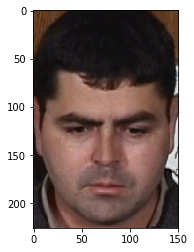

Face 1: 


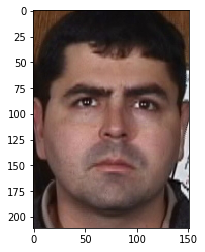

Face 2: 


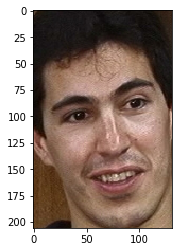

=> PREDICTION: These two images represent the same person


In [159]:
if __name__ == '__main__':
   main()